(toolboxes:analyze_everything)=
# Analyze everything

This notebook demonstrates how to run a complete STRESS analysis in a few lines of code and produce all relevant output graphs.

In [6]:
import napari_stress
import napari
import numpy as np
from napari_stress import reconstruction, approximation, measurements, frame_by_frame, TimelapseConverter
import napari_process_points_and_surfaces as nppas
import vedo

from scipy import stats

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

napari.manifest -> 'napari' could not be imported: Could not find file 'builtins.yaml' in module 'napari'


## Config

For plotting:

In [7]:
save_figures_to_dir = True
colormap = 'seismic'

### Data dimensions
You need to set a few parameters pertaining to your data:

In [8]:
voxel_size_x = 2.078  # microns
voxel_size_y = 2.078  # microns
voxel_size_z = 3.998  # microns
target_voxel_size = 2.078  # microns

### Droplet reconstruction parameters

All of the parameters are explained in more detail [here](point_and_click:droplet_reconstruction).

In [18]:
n_smoothing_iterations = 15
n_points_first_guess = 256
n_tracing_iterations = 2
resampling_length = 0.5
fit_type = 'fancy'  # can be 'fancy' or 'quick'
edge_type = 'interior'  # can be 'interior' or 'surface'
trace_length = 15
trace_sampling_distance = 1
remove_outliers = False

*Hint:* Not sure whether the code is running probably? To show a progress bar for the processing of each timeframe, set the `verbose` parameter to `True`. You can also choose to run computations of multiple timepoints in parallel by using dask. Enable this by setting the `paralellize` parameter to `True`. This is the recommended setting.

*Note*: If you parallelize computation, you can observe the progress by navigating to `https://localhost:8787` in your browser to check the progress.

In [10]:
verbose = False
parallelize = True

### Stress analysis parameters
All of the used parameters are explained in more detail [here](point_and_click:stress_toolbox).

In [11]:
max_degree = 20  # spherical harmonics degree
n_quadrature_points = 590  # number of quadrature points to measure on (maximum is 5180)
gamma = 3.3  # interfacial tension of droplet

# Analysis

In [12]:
viewer = napari.Viewer(ndisplay=3)

napari.manifest -> 'napari' could not be imported: Could not find file 'builtins.yaml' in module 'napari'


In [13]:
example_data = napari_stress.get_droplet_4d()[0][0]
example_data.shape

(21, 16, 30, 31)

In [14]:
n_frames = example_data.shape[0]

In [15]:
viewer.add_image(example_data)

<Image layer 'example_data' at 0x1cd3e17ad60>

In [19]:
results_reconstruction = reconstruction.reconstruct_droplet(example_data,
                                                            voxelsize=np.asarray([voxel_size_z, voxel_size_y, voxel_size_x]),
                                                            target_voxelsize=target_voxel_size,
                                                            n_smoothing_iterations=n_smoothing_iterations,
                                                            n_points=n_points_first_guess,
                                                            n_tracing_iterations=n_tracing_iterations,
                                                            resampling_length=resampling_length,
                                                            fit_type=fit_type,
                                                            edge_type=edge_type,
                                                            trace_length=trace_length,
                                                            sampling_distance=trace_sampling_distance,
                                                            remove_outliers=False,
                                                            verbose=verbose,
                                                            use_dask=parallelize
                                                            )

100%|██████████| 21/21 [00:04<00:00,  4.76it/s]

Dask client up an running <Client: 'tcp://127.0.0.1:64464' processes=4 threads=4, memory=31.96 GiB>  Log: https://localhost:8787


In [20]:
for res in results_reconstruction:
    if res[2] == 'image':
        viewer.add_image(res[0], **res[1])
    elif res[2] == 'points':
        viewer.add_points(res[0], **res[1])
    elif res[2] == 'vectors':
        viewer.add_vectors(res[0], **res[1])
refined_points = results_reconstruction[3]

We need the refined points to continue:

In [14]:
results_stress_analysis = measurements.comprehensive_analysis(refined_points[0],
                                                              max_degree=max_degree,
                                                              n_quadrature_points=n_quadrature_points,
                                                              gamma=gamma,
                                                              verbose=verbose,
                                                              use_dask=parallelize)
for res in results_stress_analysis:
    if res[2] == 'points':
        viewer.add_points(res[0], **res[1])
    if res[2] == 'vectors':
        viewer.add_vectors(res[0], **res[1])

100%|██████████| 21/21 [00:02<00:00,  8.69it/s]

Dask client up an running <Client: 'tcp://127.0.0.1:62716' processes=4 threads=4, memory=31.96 GiB>  Log: https://localhost:8787


# Visualization

In [15]:
mpl.style.use('default')

In [16]:
for res in results_stress_analysis:
    print(res[1]['name'])

Result of fit spherical harmonics (deg = 20
Result of expand points on ellipsoid
Result of least squares ellipsoid
Result of lebedev quadrature on ellipsoid
Result of lebedev quadrature (droplet)
Extrema total stress
Extrema cell stress
Total stress: Geodesics maxima -> nearest minima
Total stress: Geodesics minima -> nearest maxima
Cell stress: Geodesics maxima -> nearest minima
Cell stress: Geodesics minima -> nearest maxima
stress_autocorrelations


In [17]:
error_df = pd.DataFrame(results_reconstruction[3][1]['features'])
error_df

,center,amplitude,slope,background_slope,offset,center_err,amplitude_err,slope_err,background_slope_err,offset_err,mean_squared_error,fraction_variance_unexplained,fraction_variance_unexplained_log,idx_of_border
0,10.001608,165.368431,0.628295,0.362445,-0.378009,0.044336,2.130241,0.009213,0.252619,0.342601,0.350916,0.000073,-9.519896,10.001608
1,9.865734,174.669151,0.653699,-0.607124,-0.668126,0.040843,2.078870,0.009690,0.251338,0.369030,0.417361,0.000082,-9.403000,9.865734
2,9.971575,159.799804,0.593984,1.129642,0.099414,0.039981,1.829607,0.007106,0.208129,0.275570,0.206868,0.000045,-10.016038,9.971575
3,9.985500,166.902412,0.624243,0.321606,-0.345529,0.040487,1.954601,0.008292,0.231069,0.314761,0.291874,0.000060,-9.716612,9.985500
4,9.981165,156.864482,0.589975,1.133228,0.086083,0.043772,1.959592,0.007624,0.222388,0.292610,0.230900,0.000052,-9.867613,9.981165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27580,9.993774,173.601600,0.664723,-2.314152,-0.413551,0.033871,1.670570,0.008368,0.212562,0.308456,0.301482,0.000068,-9.595588,9.993774
27581,10.020324,192.539545,0.644254,-3.429050,-0.095242,0.027788,1.469460,0.006355,0.188558,0.272182,0.222548,0.000044,-10.032063,10.020324
27582,10.013936,175.295721,0.664781,-2.260581,-0.540511,0.034828,1.737155,0.008578,0.221187,0.318289,0.322596,0.000071,-9.553164,10.013936
27583,9.986996,181.635445,0.661674,-2.765685,-0.370944,0.032121,1.642374,0.007870,0.209855,0.306506,0.294140,0.000062,-9.683560,9.986996


## Spherical harmonics

### Fit residue

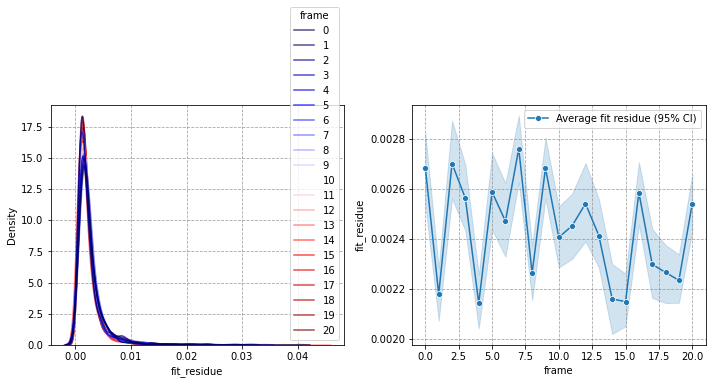

In [18]:
spherical_harmonics_data = results_stress_analysis[0]
df = pd.DataFrame(spherical_harmonics_data[1]['features'])
df['frame'] = spherical_harmonics_data[0][:, 0].astype(int)

fig, axes = plt.subplots(ncols=2, figsize=(10,5))
sns.kdeplot(data=df, x='fit_residue', hue='frame', ax=axes[0], palette=colormap, alpha=0.7)
sns.lineplot(data=df, x='frame', y='fit_residue', ci=95, ax=axes[1], legend=True, label='Average fit residue (95% CI)', marker='o')

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

### Fit quality

In [19]:
lebedev_quadrature_data = results_stress_analysis[4]
df = pd.DataFrame(lebedev_quadrature_data[1]['metadata'])
df['frame'] = np.arange(n_frames).astype(int)

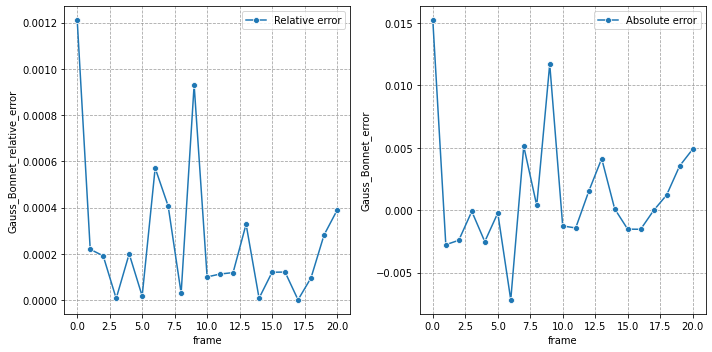

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
sns.lineplot(data=df, x='frame', y='Gauss_Bonnet_relative_error', legend=True, label='Relative error', marker='o', ax=axes[0])
sns.lineplot(data=df, x='frame', y='Gauss_Bonnet_error', legend=True, label='Absolute error', marker='o', ax=axes[1])

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

## Curvature

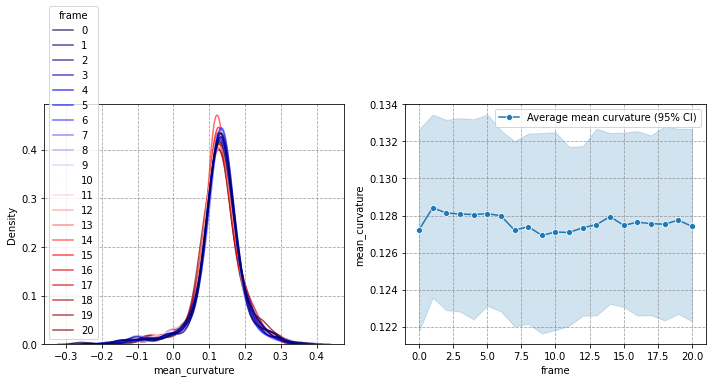

In [21]:
mean_curvature_data = results_stress_analysis[4]

df = pd.DataFrame(mean_curvature_data[1]['features'])
df['frame'] = mean_curvature_data[0][:, 0].astype(int)

fig, axes = plt.subplots(ncols=2, figsize=(10,5))
sns.kdeplot(data=df, x='mean_curvature', hue='frame', ax=axes[0], palette=colormap, alpha=0.7)
sns.lineplot(data=df, x='frame', y='mean_curvature', ci=95, ax=axes[1], legend=True, label='Average mean curvature (95% CI)', marker='o')

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

### Total stress

In [22]:
alpha=0.05

In [23]:
total_anisotropic_stress_data = results_stress_analysis[4]
df_total_stress = pd.DataFrame(total_anisotropic_stress_data[1]['features'])
df_total_stress['frame'] = total_anisotropic_stress_data[0][:, 0]

total_stress_anisotropy = []
for t in range(n_frames):
    subset_t = df_total_stress[df_total_stress['frame']==t]['anisotropic_stress']
    hist_data = np.histogram(subset_t, bins='auto', density=True)
    hist_dist = stats.rv_histogram(hist_data)
    
    smallest_excluded_value = hist_dist.ppf(alpha)
    largest_excluded_value = hist_dist.ppf(1. - alpha)
    total_stress_anisotropy.append(largest_excluded_value - smallest_excluded_value)

df_over_time = pd.DataFrame(total_stress_anisotropy, columns=['total_stress_anisotropy'])
df_over_time['frame'] = np.arange(n_frames).astype(int)

06-Feb-23 16:30:15 - asyncio  - ERROR    - Task was destroyed but it is pending!
task: <Task pending name='Task-399' coro=<HTTP1ServerConnection._server_request_loop() running at c:\Users\johan\Anaconda3\envs\stress\lib\site-packages\tornado\http1connection.py:823> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x0000019EA2D21850>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at c:\Users\johan\Anaconda3\envs\stress\lib\site-packages\tornado\ioloop.py:688]>
06-Feb-23 16:30:15 - asyncio  - ERROR    - Task was destroyed but it is pending!
task: <Task pending name='Task-432' coro=<RequestHandler._execute() running at c:\Users\johan\Anaconda3\envs\stress\lib\site-packages\tornado\web.py:1704> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x0000019EA2BE1820>()]> cb=[_HandlerDelegate.execute.<locals>.<lambda>() at c:\Users\johan\Anaconda3\envs\stress\lib\site-packages\tornado\web.py:2326]>
06-Feb-23 16:30:15 - asyncio  - ERROR    - Task was destroyed but it is p

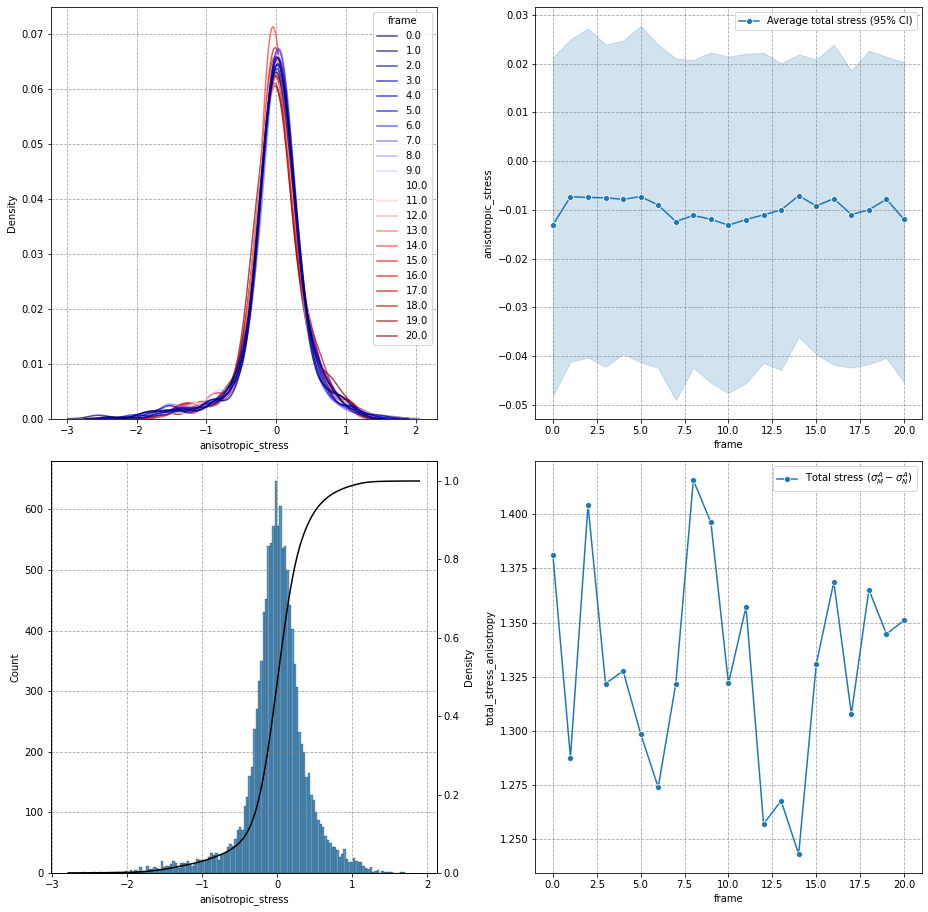

In [24]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(13,13))
axes = axes.flatten()
_ax2 = axes[2].twinx()
sns.kdeplot(data=df_total_stress, x='anisotropic_stress', hue='frame', ax=axes[0], palette=colormap, alpha=0.7)
sns.lineplot(data=df_total_stress, x='frame', y='anisotropic_stress', ci=95, ax=axes[1], legend=True, label='Average total stress (95% CI)', marker='o')
sns.histplot(data=df_total_stress, x='anisotropic_stress', ax=axes[2], label='Histogram (all frames combined)', legend=True)
sns.kdeplot(data=df_total_stress, x='anisotropic_stress', ax=_ax2, cumulative=True, label='Cumulative density function (all frames combined)', fill=False, color='black')
sns.lineplot(data=df_over_time, x='frame', y = 'total_stress_anisotropy', label='Total stress ($\sigma^A_M -  \sigma^A_N$)', marker='o', ax=axes[3])

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

### Cell-scale stress

In [25]:
alpha=0.05

In [26]:
total_anisotropic_stress_data = results_stress_analysis[4]
df_cell_stress = pd.DataFrame(total_anisotropic_stress_data[1]['features'])
df_cell_stress['frame'] = total_anisotropic_stress_data[0][:, 0]

cell_stress_anisotropy = []
for t in range(n_frames):
    subset_t = df_cell_stress[df_cell_stress['frame']==t]['anisotropic_stress_cell']
    hist_data = np.histogram(subset_t, bins='auto', density=True)
    hist_dist = stats.rv_histogram(hist_data)
    
    smallest_excluded_value = hist_dist.ppf(alpha)
    largest_excluded_value = hist_dist.ppf(1. - alpha)
    cell_stress_anisotropy.append(largest_excluded_value - smallest_excluded_value)

df_over_time['cell_stress_anisotropy'] = cell_stress_anisotropy

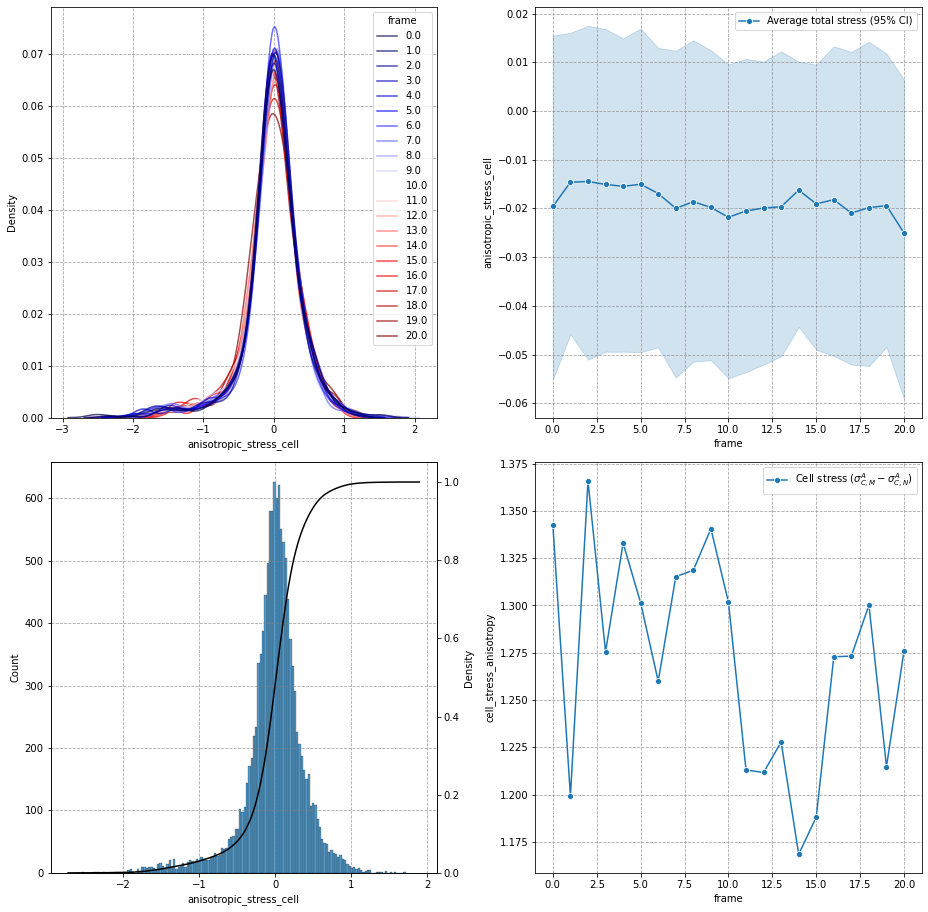

In [27]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(13,13))
axes = axes.flatten()
_ax2 = axes[2].twinx()
sns.kdeplot(data=df_cell_stress, x='anisotropic_stress_cell', hue='frame', ax=axes[0], palette=colormap, alpha=0.7)
sns.lineplot(data=df_cell_stress, x='frame', y='anisotropic_stress_cell', ci=95, ax=axes[1], legend=True, label='Average total stress (95% CI)', marker='o')
sns.histplot(data=df_cell_stress, x='anisotropic_stress_cell', ax=axes[2], label='Histogram (all frames combined)', legend=True)
sns.kdeplot(data=df_cell_stress, x='anisotropic_stress_cell', ax=_ax2, cumulative=True, label='Cumulative density function (all frames combined)', fill=False, color='black')
sns.lineplot(data=df_over_time, x='frame', y = 'cell_stress_anisotropy', label='Cell stress ($\sigma^A_{C,M} -  \sigma^A_{C,N}$)', marker='o', ax=axes[3])

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

## Tissue-scale stresses

In [28]:
tissue_anisotropic_stress_data = results_stress_analysis[3]
df_tissue_stress = pd.DataFrame(tissue_anisotropic_stress_data[1]['features'])
df_tissue_stress['frame'] = total_anisotropic_stress_data[0][:, 0]

df_over_time['max_tissue_stress_anisotropy'] = tissue_anisotropic_stress_data[1]['metadata']['max_issue_stress_anisotropy']

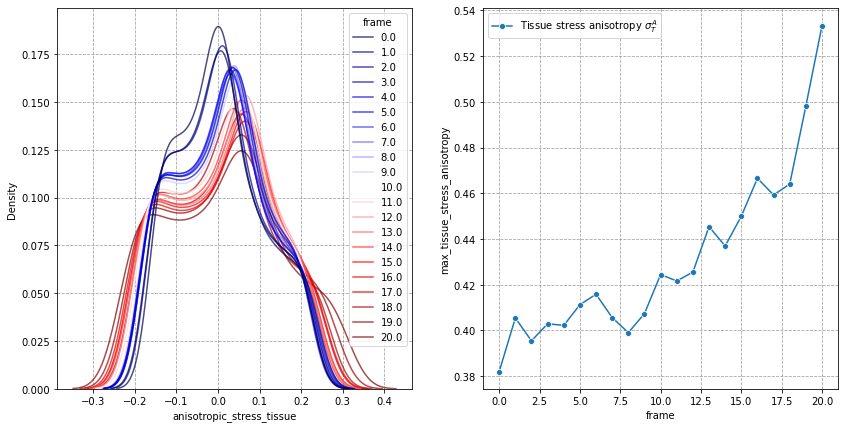

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(14,7))
axes = axes.flatten()
sns.kdeplot(data=df_tissue_stress, x='anisotropic_stress_tissue', hue='frame', ax=axes[0], palette=colormap, alpha=0.7)
sns.lineplot(data=df_over_time, x='frame', y = 'max_tissue_stress_anisotropy',
             label='Tissue stress anisotropy $\sigma^A_T$', marker='o', ax=axes[1])

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)

## Stress along axes

In [30]:
tissue_anisotropic_stress_data = results_stress_analysis[3]
tissue_tensor_elliptical = np.stack(tissue_anisotropic_stress_data[1]['metadata']['Tissue_stress_tensor_elliptical'])
tissue_tensor_cartesian = np.stack(tissue_anisotropic_stress_data[1]['metadata']['Tissue_stress_tensor_cartesian'])
df_over_time['stress_along_e1'] = tissue_tensor_elliptical[:, 0, 0]
df_over_time['stress_along_e2'] = tissue_tensor_elliptical[:, 1, 1]
df_over_time['stress_along_e3'] = tissue_tensor_elliptical[:, 2, 2]
df_over_time['stress_anisotropy_e13'] = df_over_time['stress_along_e1'] - df_over_time['stress_along_e3']
df_over_time['stress_anisotropy_e12'] = df_over_time['stress_along_e1'] - df_over_time['stress_along_e2']
df_over_time['stress_anisotropy_e23'] = df_over_time['stress_along_e2'] - df_over_time['stress_along_e3']

In [31]:
angles = np.zeros((n_frames, 3))
for i in range(n_frames):
    _tissue_tensor_elliptical = tissue_tensor_elliptical[i]
    _tissue_tensor_cartesian = tissue_tensor_cartesian[i]
    for j in range(3):
        dot_product = np.dot(_tissue_tensor_cartesian[:, j], _tissue_tensor_elliptical[:, 0])
        norm = np.linalg.norm(_tissue_tensor_cartesian[:, j]) * np.linalg.norm(_tissue_tensor_elliptical[:, 0])
        angles[i, j] = np.arccos(dot_product/norm)*180/np.pi

df_over_time['angle_x1_e1'] = angles[:, 0]
df_over_time['angle_x2_e1'] = angles[:, 1]
df_over_time['angle_x3_e1'] = angles[:, 2]

<AxesSubplot:xlabel='frame', ylabel='angle_x1_e1'>

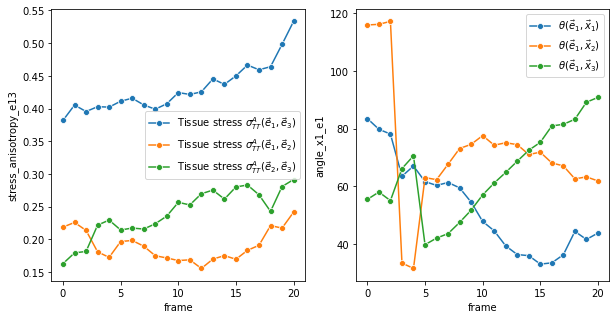

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
sns.lineplot(data=df_over_time, x='frame', y = 'stress_anisotropy_e13', label='Tissue stress $\sigma^A_{TT}(\\vec{e}_1, \\vec{e}_3)$', marker='o', ax=axes[0])
sns.lineplot(data=df_over_time, x='frame', y = 'stress_anisotropy_e12', label='Tissue stress $\sigma^A_{TT}(\\vec{e}_1, \\vec{e}_2)$', marker='o', ax=axes[0])
sns.lineplot(data=df_over_time, x='frame', y = 'stress_anisotropy_e23', label='Tissue stress $\sigma^A_{TT}(\\vec{e}_2, \\vec{e}_3)$', marker='o', ax=axes[0])
sns.lineplot(data=df_over_time, x='frame', y = 'angle_x1_e1', label='$\\theta (\\vec{e}_1, \\vec{x}_1)$', marker='o', ax=axes[1])
sns.lineplot(data=df_over_time, x='frame', y = 'angle_x2_e1', label='$\\theta (\\vec{e}_1, \\vec{x}_2)$', marker='o', ax=axes[1])
sns.lineplot(data=df_over_time, x='frame', y = 'angle_x3_e1', label='$\\theta (\\vec{e}_1, \\vec{x}_3)$', marker='o', ax=axes[1])

## Geodesics

In [33]:
extrema_cell_stress_data = results_stress_analysis[6]
metadata = extrema_cell_stress_data[1]['metadata']

In [34]:
frames = np.concatenate([[i] * len(metadata['min_max_pair_distances'][i]) for i in range(n_frames)])
min_max_pair_distances = np.concatenate(extrema_cell_stress_data[1]['metadata']['min_max_pair_distances'])
min_max_pair_anisotropies = np.concatenate(extrema_cell_stress_data[1]['metadata']['min_max_pair_anisotropies'])
df_all_pairs = pd.DataFrame(np.stack([frames.astype(int), min_max_pair_distances, min_max_pair_anisotropies]).T,
                            columns = ['frame', 'min_max_pair_distances', 'min_max_pair_anisotropies'])

In [35]:
frames = np.concatenate([[i] * len(metadata['nearest_min_max_dists'][i]) for i in range(n_frames)])
nearest_min_max_distances = np.concatenate(extrema_cell_stress_data[1]['metadata']['nearest_min_max_dists'])
nearest_min_max_anisotropies = np.concatenate(extrema_cell_stress_data[1]['metadata']['nearest_min_max_anisotropies'])
df_nearest_extrema_pairs = pd.DataFrame(np.stack([frames.astype(int), nearest_min_max_distances, nearest_min_max_anisotropies]).T,
                                        columns = ['frame', 'nearest_min_max_dists', 'nearest_min_max_anisotropies'])
df_nearest_extrema_pairs = df_nearest_extrema_pairs[df_nearest_extrema_pairs['nearest_min_max_dists'] != 0]

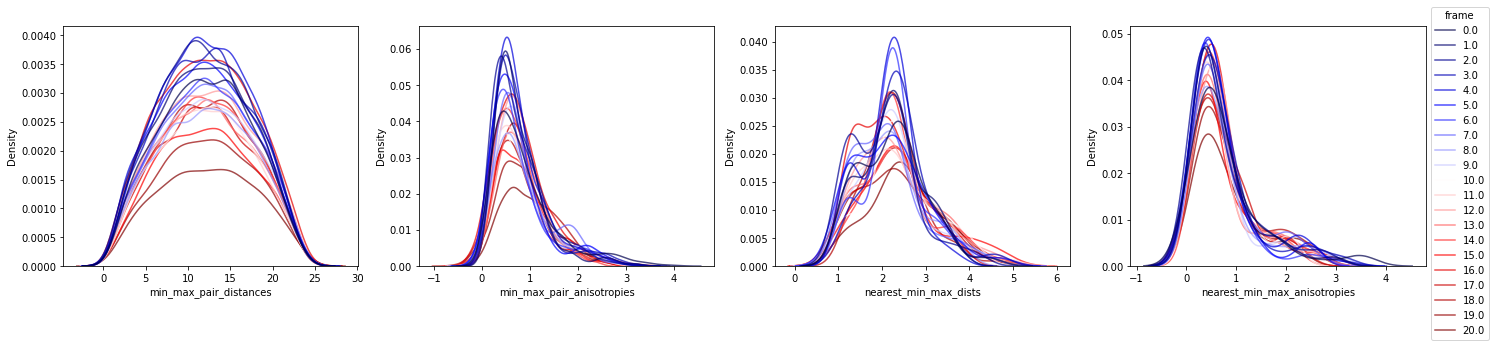

In [36]:
fig, axes = plt.subplots(ncols=4, figsize=(20,5))
sns.kdeplot(data=df_all_pairs, x='min_max_pair_distances', hue='frame', ax=axes[0], palette=colormap, alpha=0.7, legend=False)
sns.kdeplot(data=df_all_pairs, x='min_max_pair_anisotropies', hue='frame', ax=axes[1], palette=colormap, alpha=0.7, legend=False)
sns.kdeplot(data=df_nearest_extrema_pairs, x='nearest_min_max_dists', hue='frame', ax=axes[2], palette=colormap, alpha=0.7, legend=False)
sns.kdeplot(data=df_nearest_extrema_pairs, x='nearest_min_max_anisotropies', hue='frame', ax=axes[3], palette=colormap, alpha=0.7)

fig.tight_layout()
leg = axes[-1].get_legend()
leg.set_bbox_to_anchor(bbox=(1, 1.1))

##  Autocorrelations: Spatial

In [37]:
autocorrelations_data = results_stress_analysis[11]
metadata = autocorrelations_data[1]['metadata']

In [38]:
distances = [metadata['autocorrelations_total'][t]['auto_correlations_distances'] for t in range(n_frames)]
normalized_autocorrelation_total = [metadata['autocorrelations_total'][t]['auto_correlations_averaged_normalized'] for t in range(n_frames)]
frames = [[t] * len(metadata['autocorrelations_total'][t]['auto_correlations_averaged_normalized']) for t in range(n_frames)]

df_autocorrelations_total = pd.DataFrame(np.stack([np.concatenate(frames).squeeze(),
                                         np.concatenate(distances).squeeze(),
                                         np.concatenate(normalized_autocorrelation_total).squeeze(),
                                         ]).T, columns=['frame',  'distances', 'autocorrelation_total'])

In [39]:
distances = [metadata['autocorrelations_cell'][t]['auto_correlations_distances'] for t in range(n_frames)]
normalized_autocorrelation_cell = [metadata['autocorrelations_cell'][t]['auto_correlations_averaged_normalized'] for t in range(n_frames)]
frames = [[t] * len(metadata['autocorrelations_cell'][t]['auto_correlations_averaged_normalized']) for t in range(n_frames)]

df_autocorrelations_cell = pd.DataFrame(np.stack([np.concatenate(frames).squeeze(),
                                         np.concatenate(distances).squeeze(),
                                         np.concatenate(normalized_autocorrelation_cell).squeeze(),
                                         ]).T, columns=['frame',  'distances', 'autocorrelation_cell'])

In [40]:
distances = [metadata['autocorrelations_tissue'][t]['auto_correlations_distances'] for t in range(n_frames)]
normalized_autocorrelation_tissue = [metadata['autocorrelations_tissue'][t]['auto_correlations_averaged_normalized'] for t in range(n_frames)]
frames = [[t] * len(metadata['autocorrelations_tissue'][t]['auto_correlations_averaged_normalized']) for t in range(n_frames)]

df_autocorrelations_tissue = pd.DataFrame(np.stack([np.concatenate(frames).squeeze(),
                                         np.concatenate(distances).squeeze(),
                                         np.concatenate(normalized_autocorrelation_tissue).squeeze()
                                         ]).T, columns=['frame',  'distances', 'normalized_autocorrelation_tissue'])

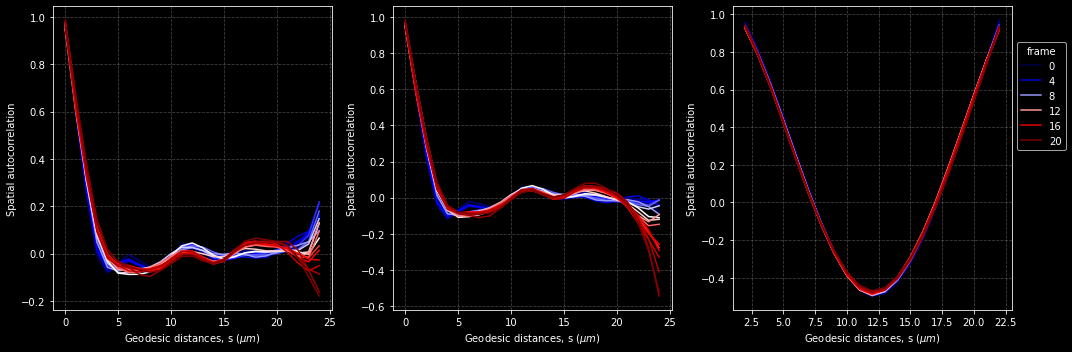

In [41]:
mpl.style.use('dark_background')
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
sns.lineplot(data=df_autocorrelations_total, x='distances', y='autocorrelation_total', hue='frame', palette=colormap, ax=axes[0], legend=False)
sns.lineplot(data=df_autocorrelations_cell, x='distances', y='autocorrelation_cell', hue='frame', palette=colormap, ax=axes[1], legend=False)
sns.lineplot(data=df_autocorrelations_tissue, x='distances', y='normalized_autocorrelation_tissue', hue='frame', palette=colormap, ax=axes[2])

leg = axes[-1].get_legend()
leg.set_bbox_to_anchor(bbox=(1, 0.9))

for ax in axes:
    ax.set_xlabel('Geodesic distances, s ($\mu m$)')
    ax.set_ylabel('Spatial autocorrelation')
    ax.grid(which='major', linestyle='--', alpha=0.5, color='gray')
fig.tight_layout()

## Autocorrelations: Temporal

In [42]:
surface_total_stress_radial = list(results_stress_analysis[11][0])
surface_total_stress_radial += [df_total_stress['anisotropic_stress_total_radial'].to_numpy()]

In [43]:
df_over_time['autocorrelation_stress_total'] = measurements.temporal_autocorrelation(df_total_stress, 'anisotropic_stress_total_radial')
df_over_time['autocorrelation_stress_cell'] = measurements.temporal_autocorrelation(df_total_stress, 'anisotropic_stress_cell')
df_over_time['autocorrelation_stress_tissue'] = measurements.temporal_autocorrelation(df_tissue_stress, 'anisotropic_stress_tissue')

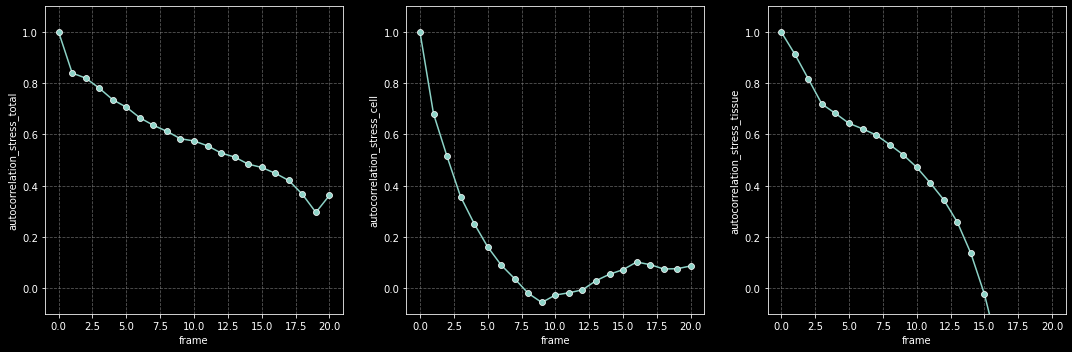

In [44]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
sns.lineplot(data=df_over_time, x='frame', y='autocorrelation_stress_total', marker='o', ax=axes[0])
sns.lineplot(data=df_over_time, x='frame', y='autocorrelation_stress_cell', marker='o', ax=axes[1])
sns.lineplot(data=df_over_time, x='frame', y='autocorrelation_stress_tissue', marker='o', ax=axes[2])
fig.tight_layout()

for ax in axes:
    ax.set_ylim(-0.1, 1.1)
    ax.grid(which='major', color='gray', linestyle='--', alpha=0.7)

## Ellipsoid deviation

In [45]:
ellipsoid_deviation_data = results_stress_analysis[0]
metadata = ellipsoid_deviation_data[1]['metadata']

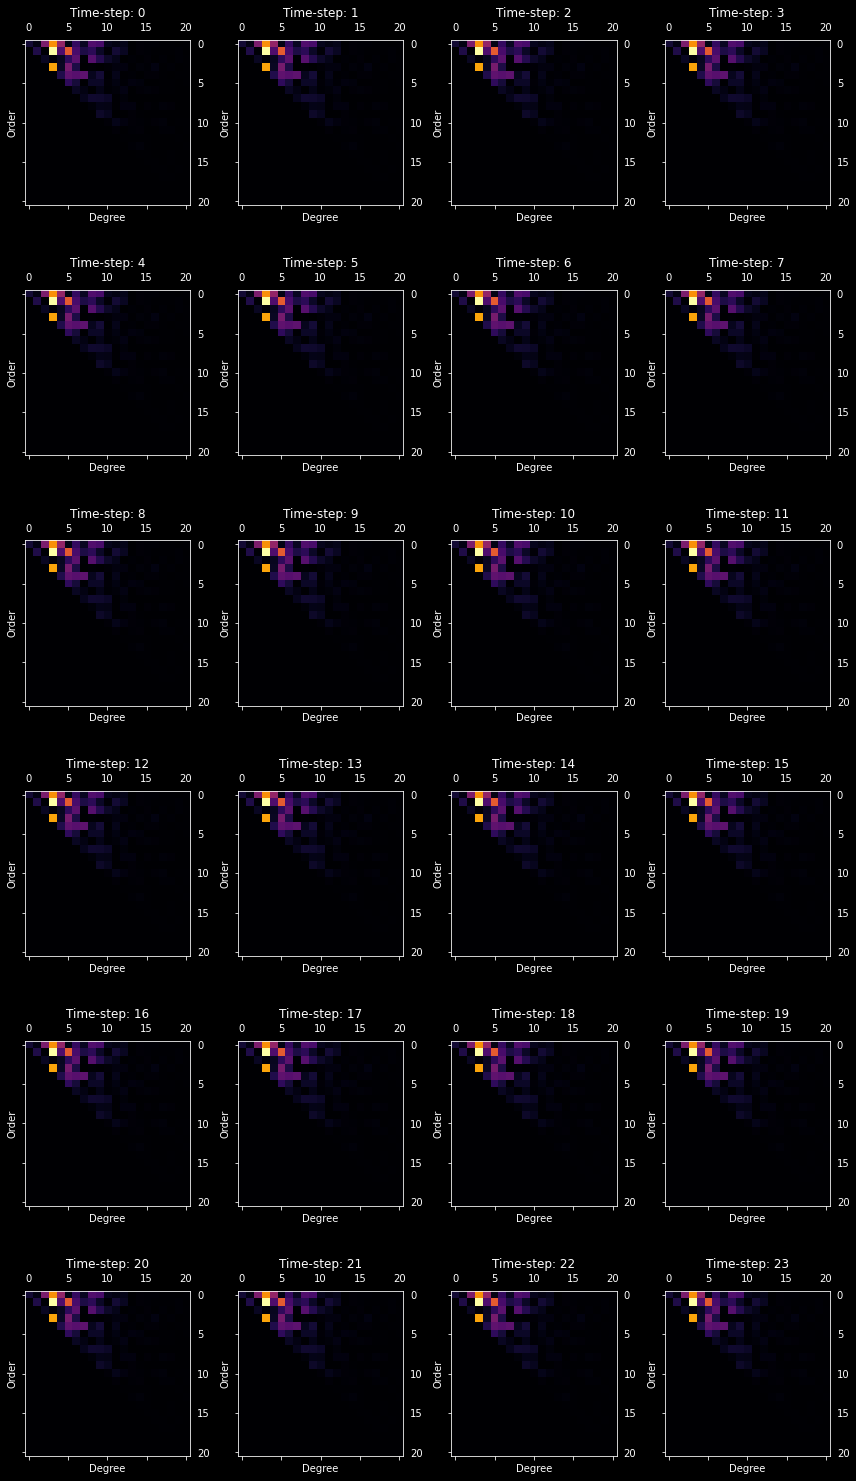

In [46]:
fig, axes = plt.subplots(ncols=4, nrows = n_frames//4 + 1, figsize=(12, n_frames))
for t, ax in enumerate(axes.flatten()):
    ax.imshow(np.triu(metadata['Elipsoid_deviation_contribution_matrix'][0]), cmap='inferno')
    ax.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)
    ax.set_xlabel('Degree')
    ax.set_ylabel('Order')
    ax.set_title(f'Time-step: {t}')

fig.tight_layout()